# All Model Errors

In [5]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [20]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 150

In [16]:
data_dir = Path('data/')

assert data_dir.exists()

In [17]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the data

In [9]:
EXPERIMENT =        'one_timestep_forecast' # '2020_04_23:190425_one_timestep_forecast' 
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

In [10]:
# read in the training data
ds = xr.open_dataset(Path(f'data/features/{TRUE_EXPERIMENT}/{DYNAMIC_DATA_FILE}'))

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(Path(f'data/interim/static/data.nc'))
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

ds['station_id'] = ds['station_id'].astype(int)

In [84]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

# Read AWS Trained Models

In [11]:
print([d.name for d in (data_dir/'gcloud').iterdir()])
print([d.name for d in (data_dir/'gcloud').glob('*_less_vars/*.csv')])

['Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC', 'conceptual_models.pkl', 'less_vars_2004_2015', 'results_lstm_less_vars_1307_1717_E015.csv', 'FUSE_bias_table.csv', 'wget-log', 'FUSE_errors.pkl', 'process_models.pkl', 'ealstm_less_vars', 'lstm20', 'fuse_csv.csv', '.ipynb_checkpoints', 'lstm_0807_2105', 'jules_classic.csv', 'plots', 'fuse_ds.nc', 'lstm_less_vars', 'all_lstm_0807_2105_results.csv', 'fuse_data.nc', 'natural_earth_hires', '3ma509dlakcf720aw8x82aq4tm.zip.1', 'FUSE_nse_all_stations.csv', 'vars', 'FUSE_r2_table.csv', 'lstm_less_vars_2004_2005_final.csv', 'ealstm20', 'FUSE_rmse_table.csv', 'FUSE', 'FUSE_nse_table.csv', 'FUSE_errors.csv']
['results_ealstm_less_vars_1307_2051_E015.csv', 'results_lstm_less_vars_1307_1717_E015.csv']


In [12]:
# lstm_less_vars = pd.read_csv(data_dir / "gcloud/lstm_less_vars/results_lstm_less_vars_1307_1717_E015.csv")
lstm_less_vars = pd.read_csv(data_dir / "gcloud/less_vars_2004_2015/all_lstm_less_vars_2004_1507_1028_results.csv")
lstm_less_vars = lstm_less_vars[["station_id", "time", "obs", "sim_E015"]].rename(columns=dict(sim_E015="sim"))
lstm_less_vars["time"] = pd.to_datetime(lstm_less_vars["time"])

# ealstm_less_vars = pd.read_csv(data_dir / "gcloud/ealstm_less_vars/results_ealstm_less_vars_1307_2051_E015.csv")
# ealstm_less_vars = pd.read_csv(data_dir / "gcloud/less_vars_2004_2015/results_ealstm_less_vars_2004_1507_2033_E007.csv")
ealstm_less_vars = pd.read_csv(data_dir / "gcloud/less_vars_2004_2015/results_ealstm_less_vars_2004_1707_1424_E011.csv")


# ealstm_less_vars = pd.read_csv(data_dir / "gcloud/less_vars_2004_2015/results_ealstm_less_vars_2004_1507_2033_E007.csv")
ealstm_less_vars["time"] = pd.to_datetime(ealstm_less_vars["time"])

In [13]:
lstm_preds = lstm_less_vars.set_index(["station_id", "time"]).to_xarray()
ealstm_preds = ealstm_less_vars.set_index(["station_id", "time"]).to_xarray()

# FUSE Data

In [21]:
all_paths = [d for d in (data_dir / "gcloud/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "gcloud/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "gcloud/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "gcloud/ALL_fuse_ds.nc")

100%|██████████| 1013/1013 [00:19<00:00, 51.91it/s]


In [22]:
fuse_ds = fuse_ds.sel(time=slice('2004-01-01', '2009-01-01'))

In [23]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["target_var_original"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

# Match Stations / Times

In [29]:
all_stations = np.isin(lstm_preds.station_id, fuse_data.station_id)

In [30]:
lstm_preds = lstm_preds.sel(station_id=all_stations, time=fuse_data.time)
ealstm_preds = ealstm_preds.sel(station_id=all_stations, time=fuse_data.time)

# Errors

In [36]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse, spatial_bias
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func, _bias_func

In [37]:
def error_func(preds_xr: xr.Dataset, error_str: str) -> pd.DataFrame:
    lookup = {
        "nse": _nse_func,
        "rmse": _rmse_func,
        "r2": _r2_func,
        "bias": _bias_func,
    }
    error_func = lookup[error_str]
    
    df = preds_xr.to_dataframe()
    df = df.dropna(how='any')
    df = df.reset_index().set_index("time")

    station_ids = df["station_id"].unique()
    errors = []
    for station_id in station_ids:
        d = df.loc[df["station_id"] == station_id]
        if error_str == "rmse":
            _error_calc = error_func(d["obs"].values, d["sim"].values, n_instances=d.size)
        else:
            _error_calc = error_func(d["obs"].values, d["sim"].values)
        errors.append(_error_calc)

    error = pd.DataFrame({"station_id": station_ids, error_str: errors})
    
    return error

In [38]:
errors = [ 
    error_func(ealstm_preds, "nse").set_index('station_id'),
    error_func(ealstm_preds, "r2").set_index('station_id'), 
    error_func(ealstm_preds, "rmse").set_index('station_id'),
    error_func(ealstm_preds, "bias").set_index('station_id'),
]
ealstm_df = errors[0].join(errors[1].join(errors[2]).join(errors[3])).reset_index()

errors = [ 
    error_func(lstm_preds, "nse").set_index('station_id'),
    error_func(lstm_preds, "r2").set_index('station_id'), 
    error_func(lstm_preds, "rmse").set_index('station_id'),
    error_func(lstm_preds, "bias").set_index('station_id'),
]
lstm_df = errors[0].join(errors[1].join(errors[2]).join(errors[3])).reset_index()

In [48]:
ealstm_nse = (
    error_func(ealstm_preds, "nse")
    .sort_values('nse')
    .reset_index()
    .drop('index', axis=1)
)
lstm_nse = (
    error_func(lstm_preds, "nse")
    .sort_values('nse')
    .reset_index()
    .drop('index', axis=1)
)
ealstm_nse['negative'] = ealstm_nse['nse'] < 0
lstm_nse['negative'] = lstm_nse['nse'] < 0

### FUSE

In [40]:
obs = fuse_data["obs"].transpose("station_id", "time")
topmodel = fuse_data["SimQ_TOPMODEL"]
arnovic = fuse_data["SimQ_ARNOVIC"]
prms = fuse_data["SimQ_PRMS"]
sacramento = fuse_data["SimQ_SACRAMENTO"]

In [41]:
top_nse = spatial_nse(obs, topmodel).rename("TOPMODEL")
vic_nse = spatial_nse(obs, arnovic).rename("VIC")
prms_nse = spatial_nse(obs, prms).rename("PRMS")
sac_nse = spatial_nse(obs, sacramento).rename("Sacramento")

In [42]:
nse = xr.merge([
    top_nse,
    vic_nse,
    prms_nse,
    sac_nse,
])
nse_df = nse.to_dataframe()
nse_df = static['gauge_name'].to_dataframe().join(nse_df).rename(columns=dict(gauge_name="Name"))
nse_df.to_csv(data_dir / 'gcloud/FUSE_nse_table.csv')
nse_df.columns = [["nse" for _ in range(len(nse_df.columns))], nse_df.columns]


In [43]:
top_rmse = spatial_rmse(obs, topmodel).rename("TOPMODEL")
vic_rmse = spatial_rmse(obs, arnovic).rename("VIC")
prms_rmse = spatial_rmse(obs, prms).rename("PRMS")
sac_rmse = spatial_rmse(obs, sacramento).rename("Sacramento")

rmse = xr.merge([
    top_rmse,
    vic_rmse,
    prms_rmse,
    sac_rmse,
])
rmse_df = rmse.to_dataframe().drop(columns='time')
rmse_df.to_csv(data_dir / 'gcloud/FUSE_rmse_table.csv')
rmse_df.columns = [["rmse" for _ in range(len(rmse_df.columns))], rmse_df.columns]


In [44]:
top_r2 = spatial_r2(obs, topmodel).rename("TOPMODEL")
vic_r2 = spatial_r2(obs, arnovic).rename("VIC")
prms_r2 = spatial_r2(obs, prms).rename("PRMS")
sac_r2 = spatial_r2(obs, sacramento).rename("Sacramento")

r2 = xr.merge([
    top_r2,
    vic_r2,
    prms_r2,
    sac_r2,
])
r2_df = r2.to_dataframe().drop(columns='time')
r2_df.to_csv(data_dir / 'gcloud/FUSE_r2_table.csv')
r2_df.columns = [["r2" for _ in range(len(r2_df.columns))], r2_df.columns]

In [45]:
top_bias = spatial_bias(obs, topmodel).rename("TOPMODEL")
vic_bias = spatial_bias(obs, arnovic).rename("VIC")
prms_bias = spatial_bias(obs, prms).rename("PRMS")
sac_bias = spatial_bias(obs, sacramento).rename("Sacramento")

bias = xr.merge([
    top_bias,
    vic_bias,
    prms_bias,
    sac_bias,
])
bias_df = bias.to_dataframe()
bias_df.to_csv(data_dir / 'gcloud/FUSE_bias_table.csv')
bias_df.columns = [["bias" for _ in range(len(bias_df.columns))], bias_df.columns]

In [46]:
fuse_errors = pd.concat([nse_df, rmse_df, r2_df, bias_df], axis=1)
fuse_errors = fuse_errors.drop('time', axis=1, level=1).swaplevel(axis=1).sort_index(axis=1)
fuse_errors.to_csv(data_dir / 'gcloud/FUSE_errors.csv')
fuse_errors.to_pickle(data_dir / 'gcloud/FUSE_errors.pkl')

In [58]:
fuse_nse_df = fuse_errors.drop(['bias', 'r2', 'rmse'], axis=1, level=1).droplevel(axis=1, level=1)
fuse_bias = fuse_errors.drop(['nse', 'r2', 'rmse'], axis=1, level=1).droplevel(axis=1, level=1)

Name       PRMS                                \
                                 nse       bias       nse        r2      rmse   
station_id                                                                      
1001                 Wick at Tarroul  12.959633  0.810740  0.817285  0.901831   
2001          Helmsdale at Kilphedir  -1.387481  0.733039  0.734121  1.278431   
2002            Brora at Bruachrobie  -3.620416  0.754227  0.760109  1.645850   
3003         Oykel at Easter Turnaig   0.064970  0.820548  0.847381  2.661060   
4001             Conon at Moy Bridge -10.896440  0.761567  0.867002  1.865888   
...                              ...        ...       ...       ...       ...   
101002               Medina at Shide   9.113285  0.272463  0.846483  0.566019   
101005      Eastern Yar at Budbridge  45.755884 -0.140124  0.828761  0.655017   
102001            Cefni at Bodffordd   0.302688  0.707917  0.708899  1.715496   
106001         Creed at Creed Bridge  -9.491457  0.849995  0.875304  1.372622   
107001        Durkadale at Durkadale        NaN       NaN       NaN       NaN   

           Sacramento                                 TOPMODEL            \
                 bias       nse        r2      rmse       bias       nse   
station_id                                                                 
1001         9.154312  0.833511  0.837479  0.845843   5.374468  0.806001   
2001       -10.049628  0.745913  0.748019  1.247226  -9.247812  0.702887   
2002        -5.275559  0.753752  0.761248  1.647439  -7.768279  0.759962   
3003        -0.250514  0.830304  0.856804  2.587714  -1.354333  0.826229   
4001       -15.224478  0.794666  0.887485  1.731542 -13.168926  0.730351   
...               ...       ...       ...       ...        ...       ...   
101002     -14.195736  0.525599  0.890973  0.457063  10.710749  0.409830   
101005       2.344623  0.561770  0.928630  0.406095 -21.583407  0.496206   
102001       2.641035  0.713261  0.713643  1.699731  -4.830856  0.717148   
106001     -11.259070  0.835965  0.865624  1.435381 -12.823300  0.824283   
107001            NaN       NaN       NaN       NaN        NaN       NaN   

                                      VIC                                
                  r2      rmse       bias       nse        r2      rmse  
station_id                                                               
1001        0.809666  0.913054  16.555672  0.782846  0.793040  0.966006  
2001        0.706194  1.348697  -4.731616  0.724460  0.724825  1.298811  
2002        0.768166  1.626535  -2.018369  0.731940  0.736821  1.718855  
3003        0.853982  2.618600  -0.665297  0.818363  0.844341  2.677211  
4001        0.853633  1.984275  -3.269556  0.814088  0.894459  1.647614  
...              ...       ...        ...       ...       ...       ...  
101002      0.857931  0.509791  -6.368953  0.485665  0.900020  0.475912  
101005      0.914257  0.435415  26.253056  0.362535  0.911410  0.489784  
102001      0.717326  1.688169  17.373095  0.731435  0.733118  1.644983  
106001      0.857192  1.485611  -4.030308  0.864790  0.886005  1.303174  
107001           NaN       NaN        NaN       NaN       NaN       NaN  

[671 rows x 17 columns]

# Overall Model Performance Comparison

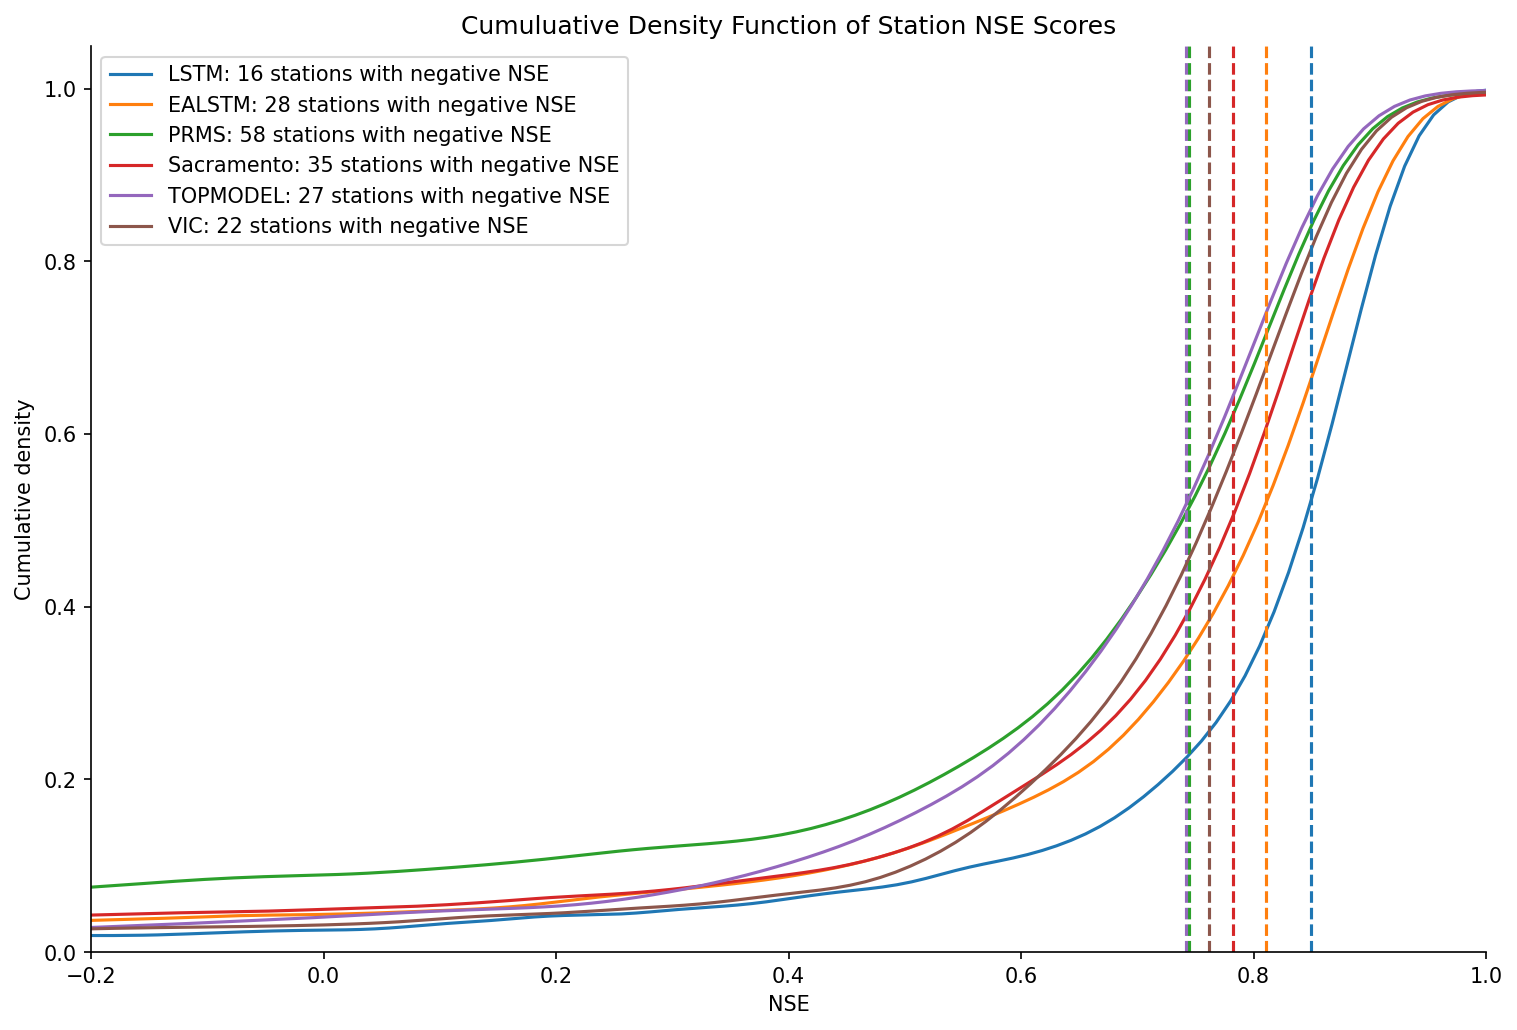

In [55]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_nse['nse'], 
    cumulative=True, 
    legend=False, ax=ax, 
    clip=[-0.5,1], 
    label=f"LSTM: {lstm_nse['negative'].sum()} stations with negative NSE"
)
sns.kdeplot(
    ealstm_nse['nse'], 
    cumulative=True, 
    legend=False, ax=ax, 
    clip=[-0.5,1], 
    label=f"EALSTM: {ealstm_nse['negative'].sum()} stations with negative NSE"
)

for conceptual_ix, model in enumerate([c for c in fuse_nse_df.columns if (not "Name" in c) and (not "station" in c)]):
    sns.kdeplot(
        fuse_nse_df[model].dropna(), 
        cumulative=True, 
        legend=False, ax=ax, 
        clip=[-0.5,1], 
        label=f"{model}: {(fuse_nse_df[model] < 0).sum()} stations with negative NSE"
    )
    plt.legend()
    ax.axvline(fuse_nse_df[model].dropna().median(), ls="--", color=colors[conceptual_ix+2])


ax.axvline(lstm_nse['nse'].median(), ls="--", color=colors[0])
ax.axvline(ealstm_nse['nse'].median(), ls="--", color=colors[1])

ax.set_xlim([-0.2, 1])
ax.set_xlabel("NSE")
ax.set_ylabel("Cumulative density")
title = f"Cumuluative Density Function of Station NSE Scores"
ax.set_title(title)
sns.despine()

# Bias

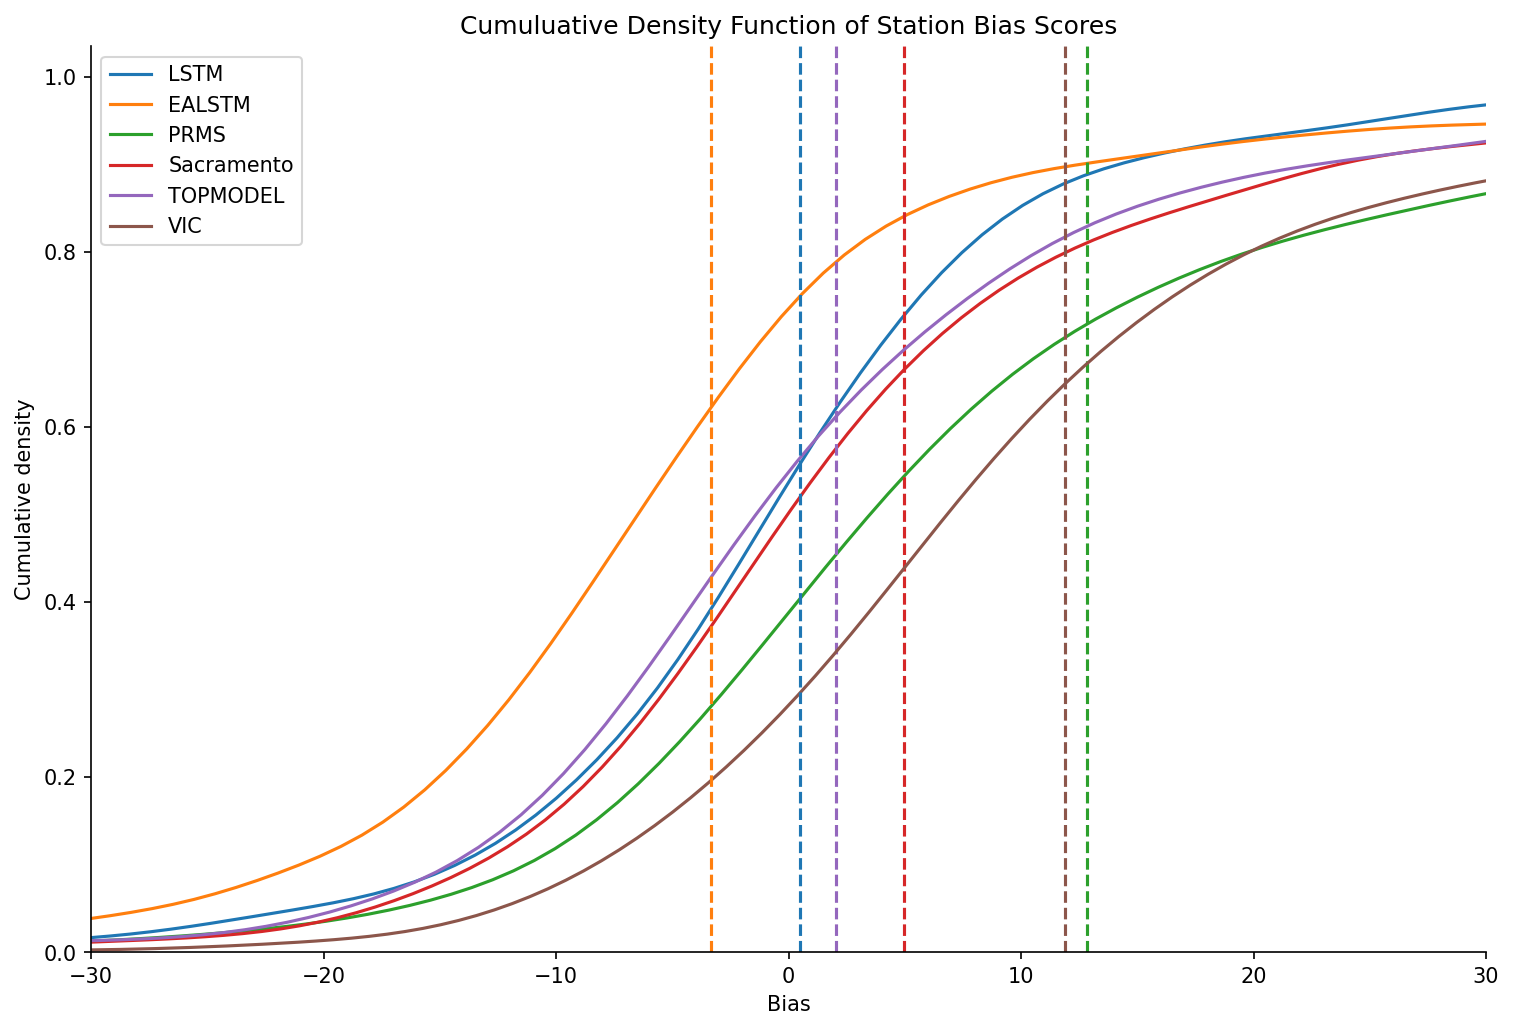

In [82]:
colors = sns.color_palette()
cumulative = True


fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_df['bias'], 
    cumulative=cumulative, 
    legend=False, ax=ax, 
    clip=[-50, 50], 
    label=f"LSTM"
)
sns.kdeplot(
    ealstm_df['bias'],
    cumulative=cumulative, 
    legend=False, ax=ax, 
    clip=[-50, 50], 
    label=f"EALSTM"
)

for conceptual_ix, model in enumerate([model for model in fuse_bias]):
    sns.kdeplot(
        fuse_bias[model].dropna(), 
        cumulative=cumulative, 
        legend=False, ax=ax, 
        label=f"{model}",
        clip=[-50,50],
    )
    plt.legend()
    ax.axvline(fuse_bias[model].dropna().mean(), ls="--", color=colors[conceptual_ix+2])


ax.axvline(lstm_df['bias'].mean(), ls="--", color=colors[0])
ax.axvline(ealstm_df['bias'].mean(), ls="--", color=colors[1])

ax.set_xlim([-30, 30])
ax.set_xlabel("Bias")

if cumulative:
    ax.set_ylabel("Cumulative density")
    title = f"Cumuluative Density Function of Station Bias Scores"
else:
    title = f"Density of Station Bias Scores"
    ax.set_ylabel("Density")
# ax.axvline(ls="--", color='grey', ) # label="Zero Bias", 
ax.set_title(title)
plt.legend()
sns.despine()

In [81]:
print(f"LSTM Bias: {lstm_df['bias'].mean():.2f}")
print(f"EALSTM Bias: {ealstm_df['bias'].mean():.2f}")

for model in [model for model in fuse_bias]:
    print(f"{model} Bias: {fuse_bias[model].dropna().mean():.2f}")

LSTM Bias: 0.51
EALSTM Bias: -3.34
PRMS Bias: 12.85
Sacramento Bias: 4.98
TOPMODEL Bias: 2.05
VIC Bias: 11.87


# Tables

In [85]:
process_errors = pd.read_csv(data_dir / "gcloud/jules_classic.csv")

classic = process_errors.loc[process_errors["Model"] == "Classic", :].drop('Model', axis=1)
classic = classic.rename(columns={"ID": "Station ID"}).set_index("Station ID")
classic.columns = [["CLASSIC" for _ in range(len(classic.columns))], classic.columns]

jules = process_errors.loc[process_errors["Model"] == "Jules", :].drop('Model', axis=1)
jules = jules.rename(columns={"ID": "Station ID"}).set_index("Station ID").drop("Name", axis=1)
jules.columns = [["JULES" for _ in range(len(jules.columns))], jules.columns]

process_errors = pd.concat([classic, jules], axis=1)
process_errors.to_pickle(data_dir / "gcloud/process_models.pkl")
process_errors

CLASSIC             JULES      
                                  Name   NSE  Bias   NSE  Bias
Station ID                                                    
12002                     Dee at Park   0.55  -3.4  0.51 -20.0
15006                Tay at Ballathie   0.46  -7.7  0.64 -15.0
27009                 Ouse at Skelton   0.80   3.1  0.69 -18.0
27034           Ure at Kilgram Bridge   0.78   2.8  0.75 -19.0
27041         Derwent at Buttercrambe   0.65  -5.3  0.49 -27.0
39001              Thames at Kingston   0.81  -5.9  0.82 -11.0
39081                 Ock at Abingdon   0.80 -13.6 -0.21 -63.0
43021              Avon at Knapp Mill   0.60 -17.6 -0.07 -20.0
47001             Tamar at Gunnislake   0.82   0.6  0.63 -18.0
54001               Severn at Bewdley   0.66   4.6  0.61  -7.0
54057            Severn at Haw Bridge   0.78   2.1  0.72 -14.0
71001            Ribble at Samlesbury   0.73   0.4  0.74 -18.0
84013               Clyde at Daldowie   0.80  -2.5  0.82 -24.0

In [126]:
fuse_nse = fuse_errors.drop(["rmse", "bias", "r2"], axis=1, level=1).droplevel(axis=1, level=1)
fuse_rmse = fuse_errors.drop(["nse", "bias", "r2"], axis=1, level=1).droplevel(axis=1, level=1)
fuse_bias = fuse_errors.drop(["rmse", "nse", "r2"], axis=1, level=1).droplevel(axis=1, level=1)
fuse_r2 = fuse_errors.drop(["rmse", "bias", "nse"], axis=1, level=1).droplevel(axis=1, level=1)

fuse_nse = fuse_nse.join(fuse_errors.iloc[:, 0]).rename({("Name", "nse"): 'Name'}, axis=1)
fuse_rmse = fuse_rmse.join(fuse_errors.iloc[:, 0]).rename({("Name", "nse"): 'Name'}, axis=1)
fuse_bias = fuse_bias.join(fuse_errors.iloc[:, 0]).rename({("Name", "nse"): 'Name'}, axis=1)
fuse_r2 = fuse_r2.join(fuse_errors.iloc[:, 0]).rename({("Name", "nse"): 'Name'}, axis=1)

In [128]:
# NSE
nse = fuse_nse_df.join(
    ealstm_df.set_index("station_id")["nse"].rename("EALSTM")
)
nse = nse.join(
    lstm_df.set_index("station_id")["nse"].rename("LSTM")
)

# RMSE
rmse = fuse_rmse.join(
    ealstm_df.set_index("station_id")["rmse"].rename("EALSTM")
)
rmse = rmse.join(
    lstm_df.set_index("station_id")["rmse"].rename("LSTM")
)
rmse['Name'] = nse["Name"]
rmse = rmse[["Name"] + [c for c in rmse.columns if c != "Name"]]

# R2
r2 = fuse_r2.join(
    ealstm_df.set_index("station_id")["r2"].rename("EALSTM")
)
r2 = r2.join(
    lstm_df.set_index("station_id")["r2"].rename("LSTM")
)
r2['Name'] = nse["Name"]
r2 = r2[["Name"] + [c for c in r2.columns if c != "Name"]]


# BIAS
bias = fuse_bias.join(
    ealstm_df.set_index("station_id")["bias"].rename("EALSTM")
)
bias = bias.join(
    lstm_df.set_index("station_id")["bias"].rename("LSTM")
)
bias['Name'] = nse["Name"]
bias = bias[["Name"] + [c for c in bias.columns if c != "Name"]]

In [131]:
nse_13 = nse.loc[catchment_ids]
nse_13.index.name = "Station ID"
rmse_13 = rmse.loc[catchment_ids]
rmse_13.index.name = "Station ID"
r2_13 = r2.loc[catchment_ids]
r2_13.index.name = "Station ID"
bias_13 = bias.loc[catchment_ids]
bias_13.index.name = "Station ID"

In [132]:
all_bias = bias_13.join(process_errors.drop(["NSE", "Name"], axis=1, level=1).droplevel(axis=1, level=1))

In [133]:
all_nse = nse_13.join(process_errors.drop(["Bias", "Name"], axis=1, level=1).droplevel(axis=1, level=1))

In [134]:
print(all_nse.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrr}
\toprule
{} &                     Name &  PRMS &  Sacramento &  TOPMODEL &  VIC &  EALSTM &  LSTM &  CLASSIC &  JULES \\
Station ID &                          &       &             &           &      &         &       &          &        \\
\midrule
12002      &              Dee at Park &  0.65 &        0.65 &      0.56 & 0.63 &    0.82 &  0.87 &     0.55 &   0.51 \\
15006      &         Tay at Ballathie &  0.86 &        0.88 &      0.80 & 0.89 &    0.94 &  0.94 &     0.46 &   0.64 \\
27009      &          Ouse at Skelton &  0.88 &        0.90 &      0.86 & 0.89 &    0.86 &  0.91 &     0.80 &   0.69 \\
27034      &    Ure at Kilgram Bridge &  0.85 &        0.85 &      0.84 & 0.85 &    0.86 &  0.85 &     0.78 &   0.75 \\
27041      &  Derwent at Buttercrambe &  0.78 &        0.81 &      0.75 & 0.71 &    0.78 &  0.84 &     0.65 &   0.49 \\
39001      &       Thames at Kingston &  0.63 &        0.82 &      0.73 & 0.73 &    0.65 &  0.87 &     0.81 &   0.82 \\
39

In [135]:
print(all_bias.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrr}
\toprule
{} &                     Name &  PRMS &  Sacramento &  TOPMODEL &    VIC &  EALSTM &   LSTM &  CLASSIC &  JULES \\
Station ID &                          &       &             &           &        &         &        &          &        \\
\midrule
12002      &              Dee at Park & -3.04 &       -7.21 &     -5.94 &   7.12 &  -14.07 &  -0.37 &    -3.40 & -20.00 \\
15006      &         Tay at Ballathie & -7.01 &       -8.62 &     -8.81 &   7.22 &   -5.02 &  -6.47 &    -7.70 & -15.00 \\
27009      &          Ouse at Skelton &  3.04 &        3.38 &      3.98 &   8.81 &  -10.82 &  -4.56 &     3.10 & -18.00 \\
27034      &    Ure at Kilgram Bridge & -0.92 &       -9.45 &     -6.60 &  -3.46 &   -4.39 &  -2.93 &     2.80 & -19.00 \\
27041      &  Derwent at Buttercrambe & 10.31 &       10.90 &      1.41 &  20.46 &   -7.51 & -11.70 &    -5.30 & -27.00 \\
39001      &       Thames at Kingston & 46.28 &       21.18 &     16.53 &  17.65 &    0.51 &   9.25 &

# Spatial Plots

In [137]:
fuse_errors.head()

Name       PRMS                                \
                                nse       bias       nse        r2      rmse   
station_id                                                                     
1001                Wick at Tarroul  12.959633  0.810740  0.817285  0.901831   
2001         Helmsdale at Kilphedir  -1.387481  0.733039  0.734121  1.278431   
2002           Brora at Bruachrobie  -3.620416  0.754227  0.760109  1.645850   
3003        Oykel at Easter Turnaig   0.064970  0.820548  0.847381  2.661060   
4001            Conon at Moy Bridge -10.896440  0.761567  0.867002  1.865888   

           Sacramento                                 TOPMODEL            \
                 bias       nse        r2      rmse       bias       nse   
station_id                                                                 
1001         9.154312  0.833511  0.837479  0.845843   5.374468  0.806001   
2001       -10.049628  0.745913  0.748019  1.247226  -9.247812  0.702887   
2002        -5.275559  0.753752  0.761248  1.647439  -7.768279  0.759962   
3003        -0.250514  0.830304  0.856804  2.587714  -1.354333  0.826229   
4001       -15.224478  0.794666  0.887485  1.731542 -13.168926  0.730351   

                                      VIC                                
                  r2      rmse       bias       nse        r2      rmse  
station_id                                                               
1001        0.809666  0.913054  16.555672  0.782846  0.793040  0.966006  
2001        0.706194  1.348697  -4.731616  0.724460  0.724825  1.298811  
2002        0.768166  1.626535  -2.018369  0.731940  0.736821  1.718855  
3003        0.853982  2.618600  -0.665297  0.818363  0.844341  2.677211  
4001        0.853633  1.984275  -3.269556  0.814088  0.894459  1.647614

In [141]:
vic_errors = fuse_errors.drop(['Name', 'PRMS', "Sacramento", "TOPMODEL"], axis=1, level=0).droplevel(axis=1, level=0)
prms_errors = fuse_errors.drop(['Name', 'VIC', "Sacramento", "TOPMODEL"], axis=1, level=0).droplevel(axis=1, level=0)
top_errors = fuse_errors.drop(['Name', 'PRMS', "Sacramento", "VIC"], axis=1, level=0).droplevel(axis=1, level=0)
sac_errors = fuse_errors.drop(['Name', 'PRMS', "VIC", "TOPMODEL"], axis=1, level=0).droplevel(axis=1, level=0)

In [151]:
import geopandas as gpd

shp_path = Path(
    "/home/jovyan/runoff_uk_lstm/data/CAMELS/CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
)
assert shp_path.exists()

# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}  # 4277  27700


In [156]:
# create spatial dataframe
assert lstm_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
lstm_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(lstm_df.set_index('station_id').join(static['p_mean'].to_dataframe()))
)

assert ealstm_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
ealstm_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(ealstm_df.set_index('station_id').join(static['p_mean'].to_dataframe()))
)


# CONCEPTUAL MODELS
assert vic_errors.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
vic_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(vic_errors.join(static['p_mean'].to_dataframe()))
)

assert prms_errors.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
prms_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(prms_errors.join(static['p_mean'].to_dataframe()))
)

assert top_errors.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
top_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(top_errors.join(static['p_mean'].to_dataframe()))
)

assert sac_errors.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
sac_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(sac_errors.join(static['p_mean'].to_dataframe()))
)


lstm_gdf.crs = {'init' :'epsg:27700'}
ealstm_gdf.crs = {'init' :'epsg:27700'}
vic_gdf.crs = {'init' :'epsg:27700'}
prms_gdf.crs = {'init' :'epsg:27700'}
top_gdf.crs = {'init' :'epsg:27700'}
sac_gdf.crs = {'init' :'epsg:27700'}

## Get UK Boundaries

Get the COUNTY SHAPE data [here:](https://opendata.arcgis.com/datasets/1919db8ffcc5445ea4ba5b8a10acfccd_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D)
```
!wget https://opendata.arcgis.com/datasets/1919db8ffcc5445ea4ba5b8a10acfccd_0.zip
!unzip 1919db8ffcc5445ea4ba5b8a10acfccd_0.zip
!mkdir Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC
!mv Counties* Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC
```

Get all of these shapefiles and merge into one big polygon
```python
uk = gpd.read_file(data_dir / "gcloud/Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC/Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC.shp")
uk.plot()

from shapely.ops import unary_union  # cascaded_union, 
uk_bound = unary_union([p for p in uk.geometry])
uk_bound = gpd.GeoSeries(uk_bound)
```

[Link to CRS Discussion](https://communityhub.esriuk.com/geoxchange/2012/3/26/coordinate-systems-and-projections-for-beginners.html#:~:text=If%20you%20work%20with%20UK,that%20you%20should%20know%20about.&text=Web%20Mercator%20is%20a%20PCS,36%20used%20for%20British%20maps)


![title](https://static1.squarespace.com/static/55bb8935e4b046642e9d3fa7/55bb8e8ee4b03fcc125a74c0/55bb8e91e4b03fcc125a7a67/1331725592717/1000w/coordsys_diagram.png)


In [157]:
world = gpd.read_file(data_dir / "gcloud/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [169]:
opts = {
    "rmse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis'},   # rmse   
    "rmse_norm": {"vmin": 0, "vmax": 0.5, 'cmap': 'viridis'},   # rmse   
    "nse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'},    # nse   
    "r2": {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'},    # r2  
    "bias": {"vmin": -30, "vmax": 30, 'cmap': 'RdBu'}    # r2  
}


def plot_geospatial_data(model_data, model: str):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    
    for ix, metric in enumerate(["rmse", "nse", "bias"]):
        ax = axs[ix]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs

        # plot the surrounding lines
        uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
        # plot the chloropleth
        model_data.to_crs(epsg=4326).plot(metric, ax=ax, legend=True, cax=cax, **opts[metric]);

        ax.set_xlim([-8.2, 2.5])
        ax.axis('off');

        ax.set_title(metric.upper())

    fig.tight_layout(rect=[0, 0.03, 1, 0.965])
    fig.suptitle(f"{model} Model Error", size=14)

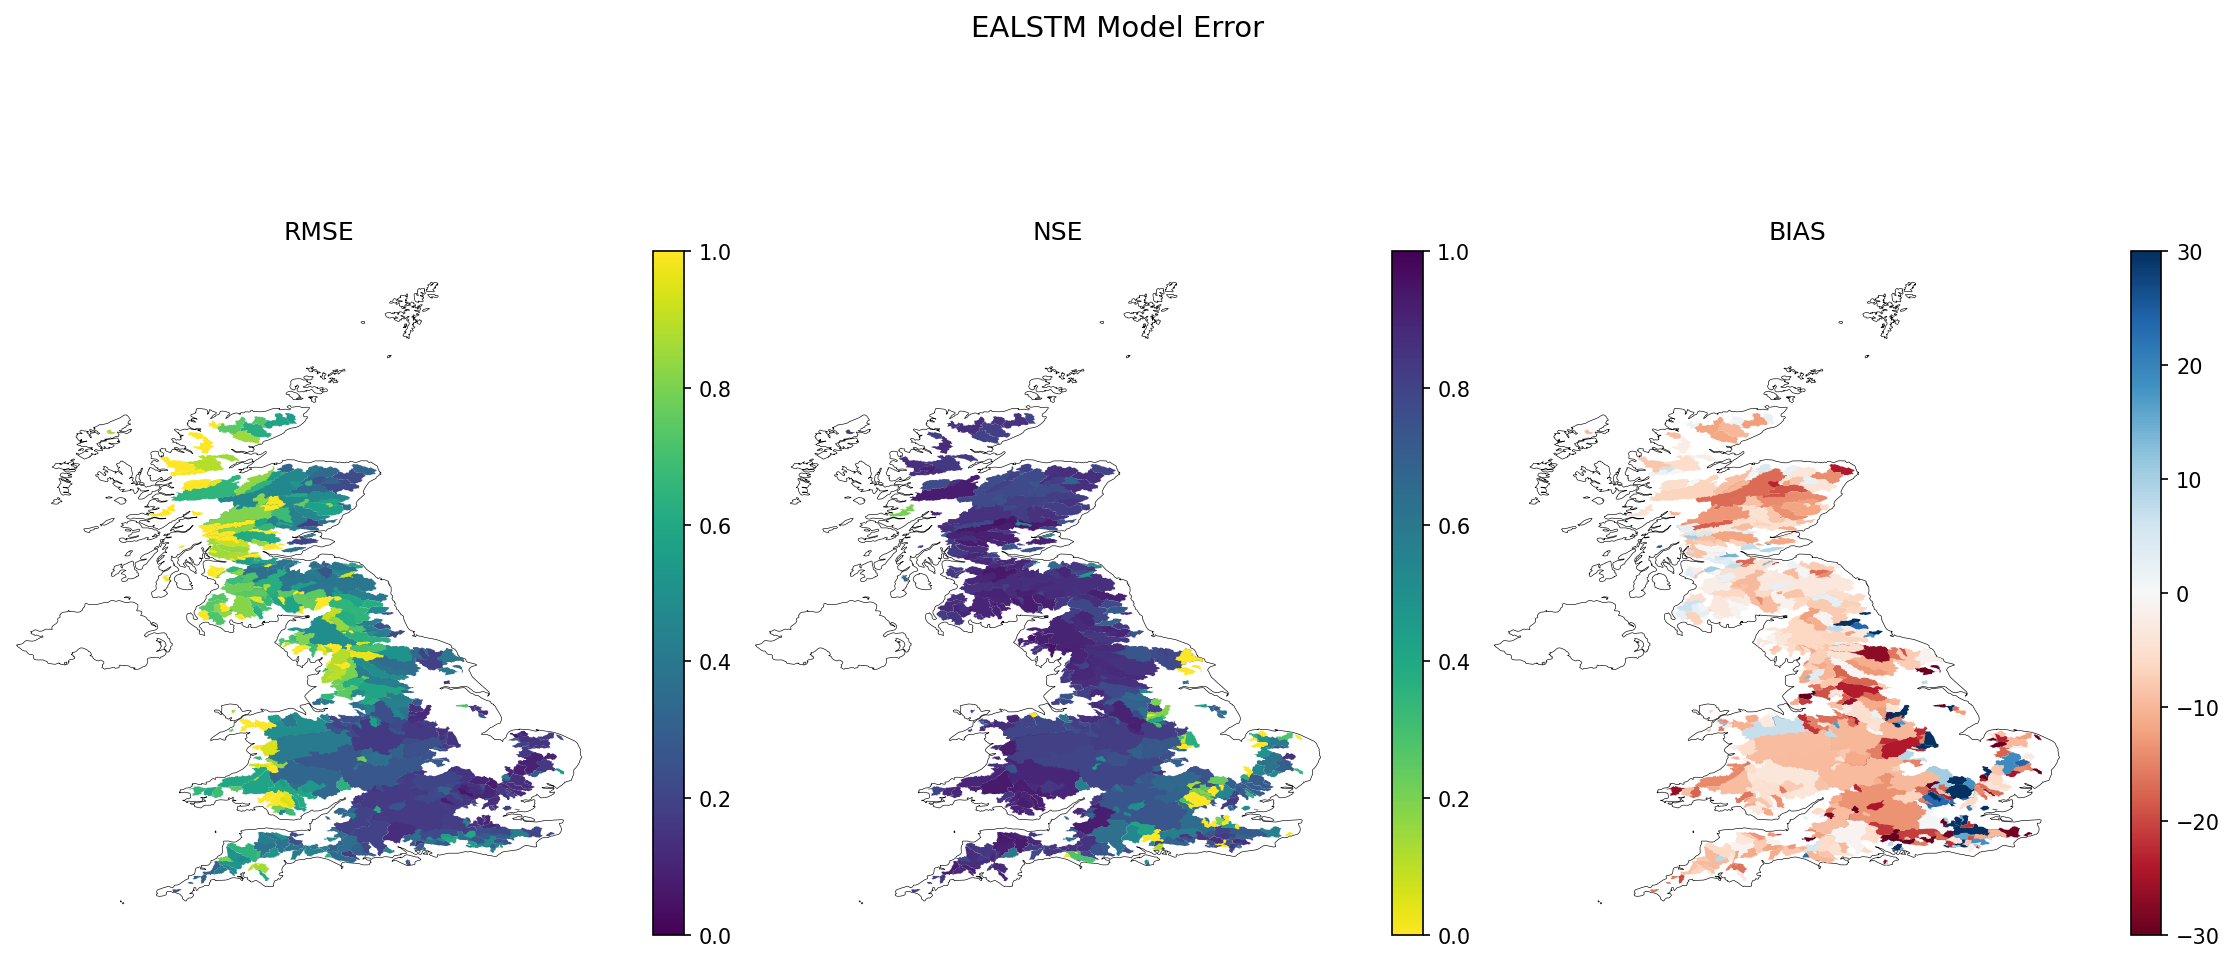

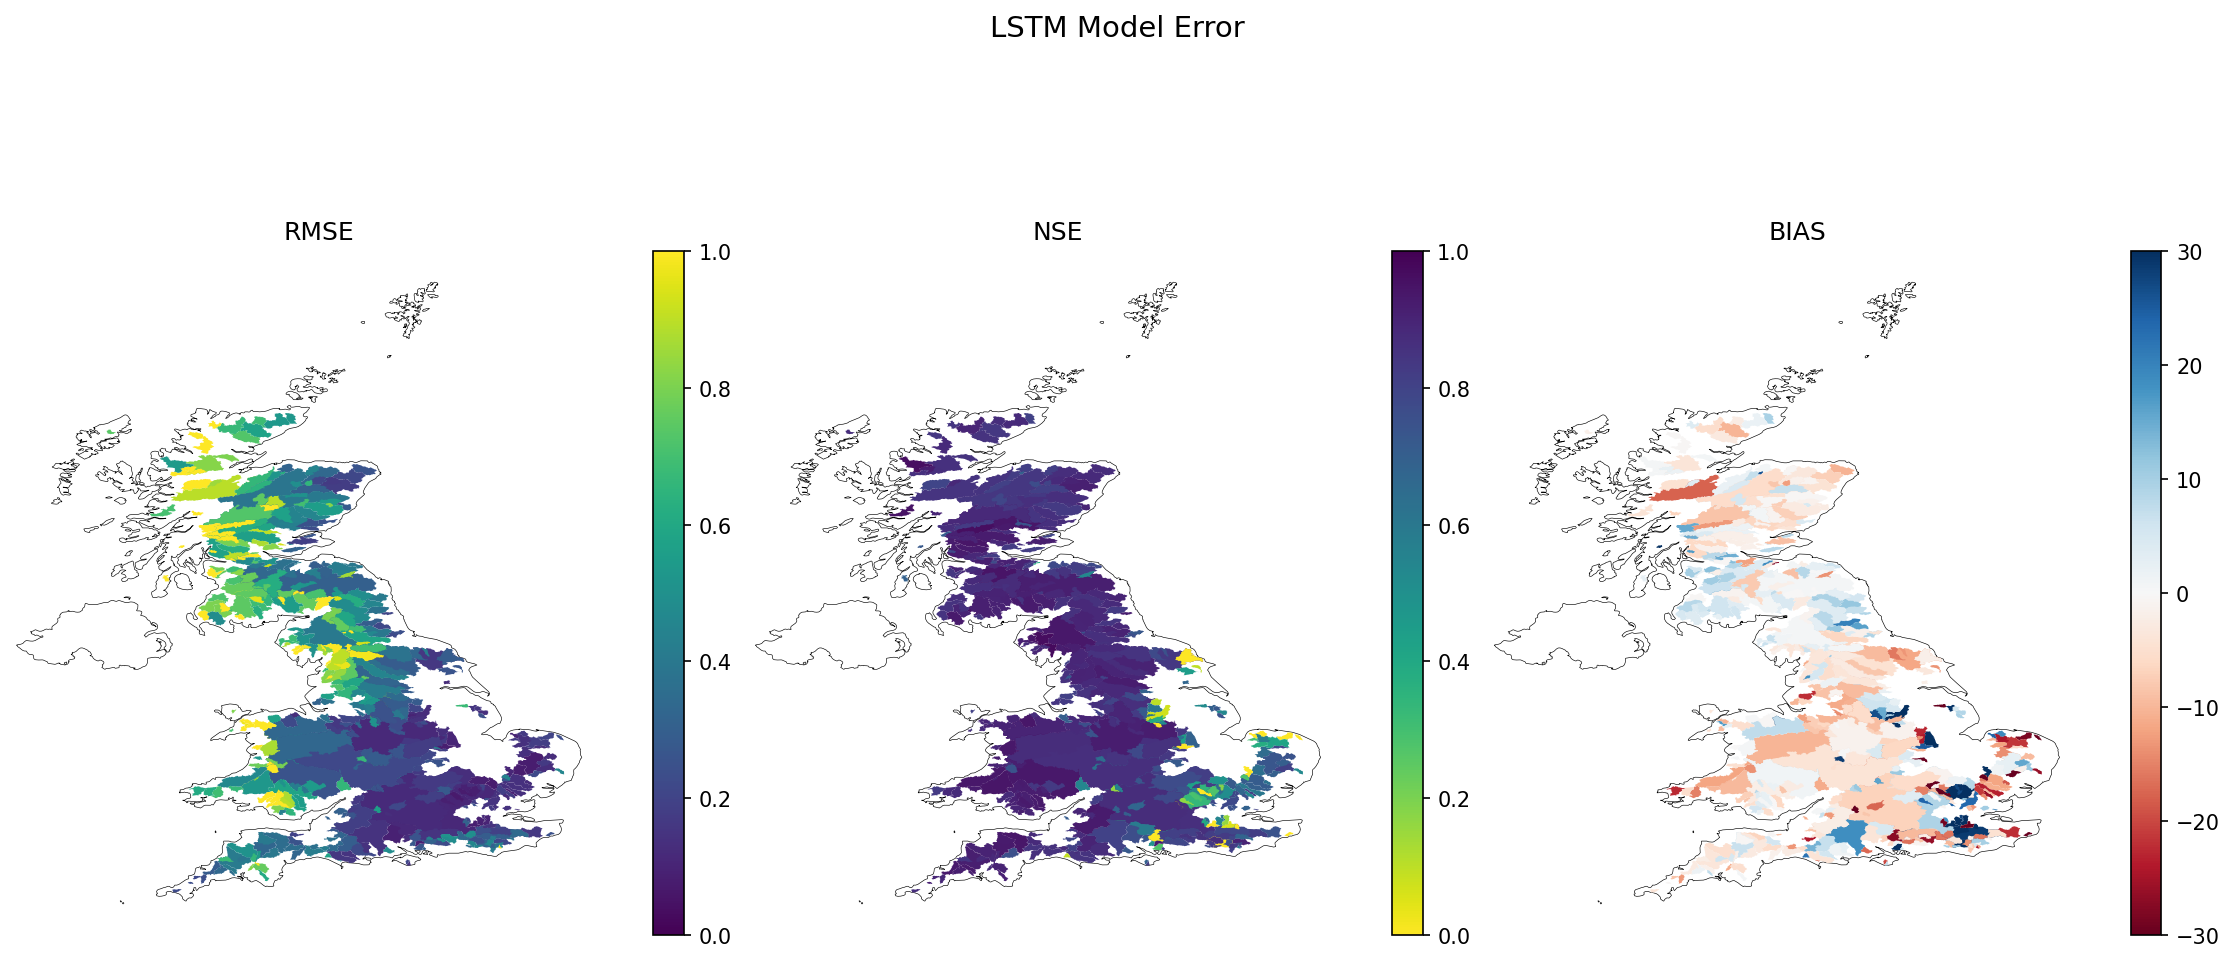

In [172]:
plot_geospatial_data(ealstm_gdf, model="EALSTM")
plot_geospatial_data(lstm_gdf, model="LSTM")

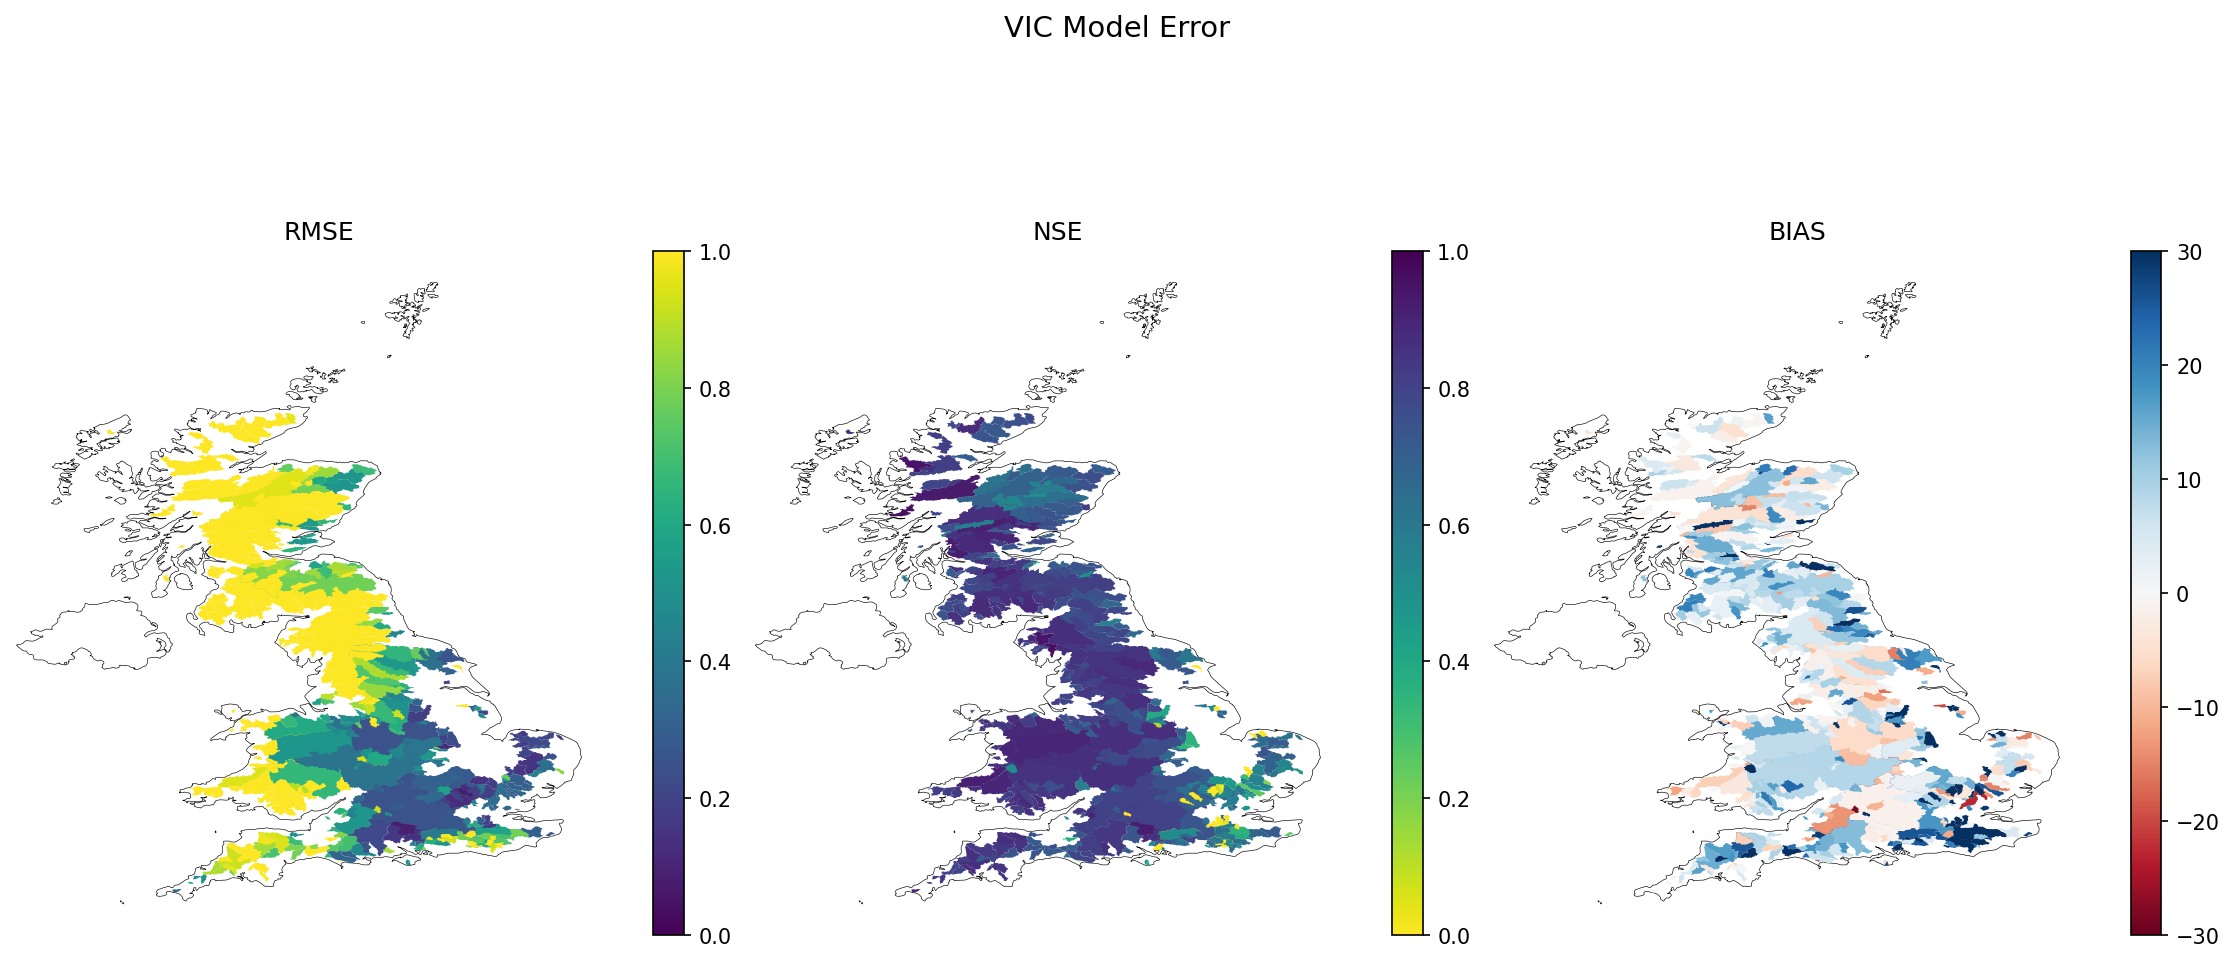

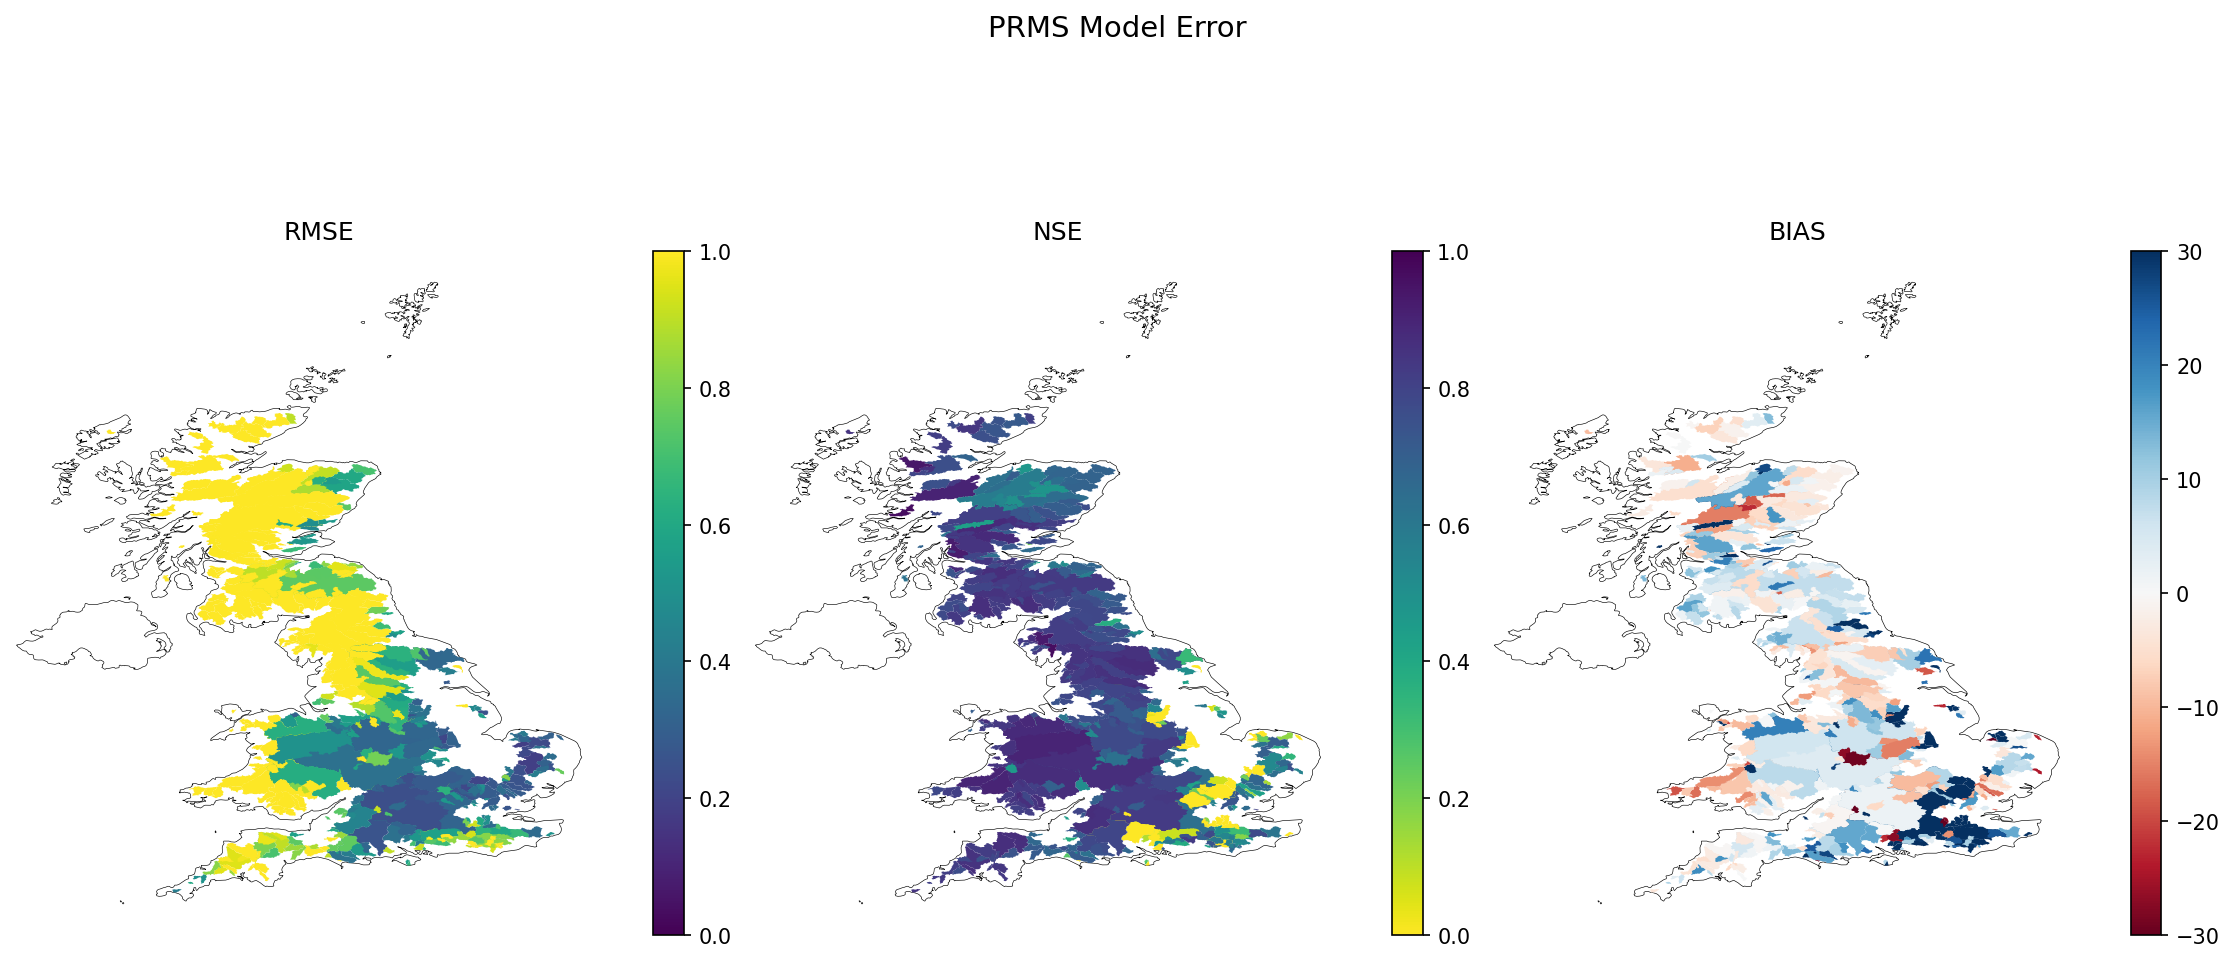

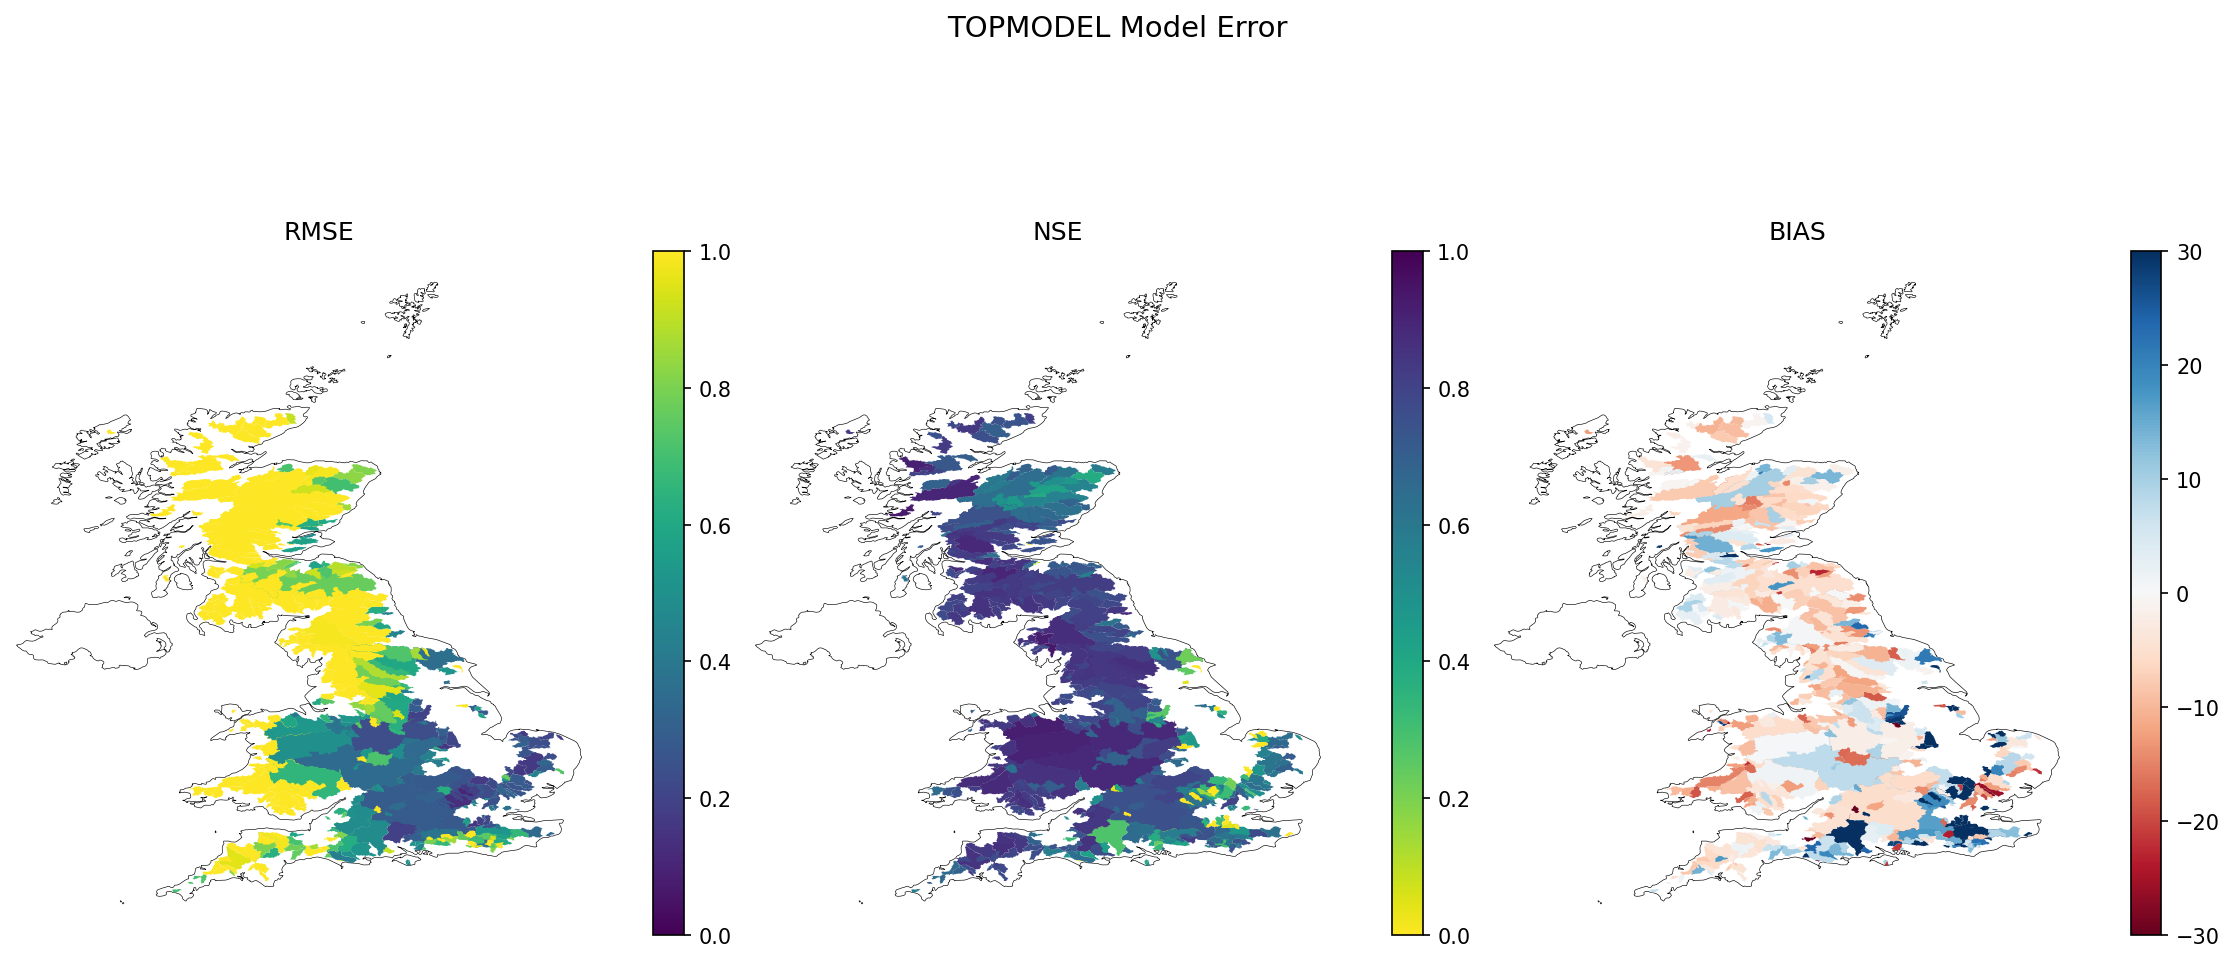

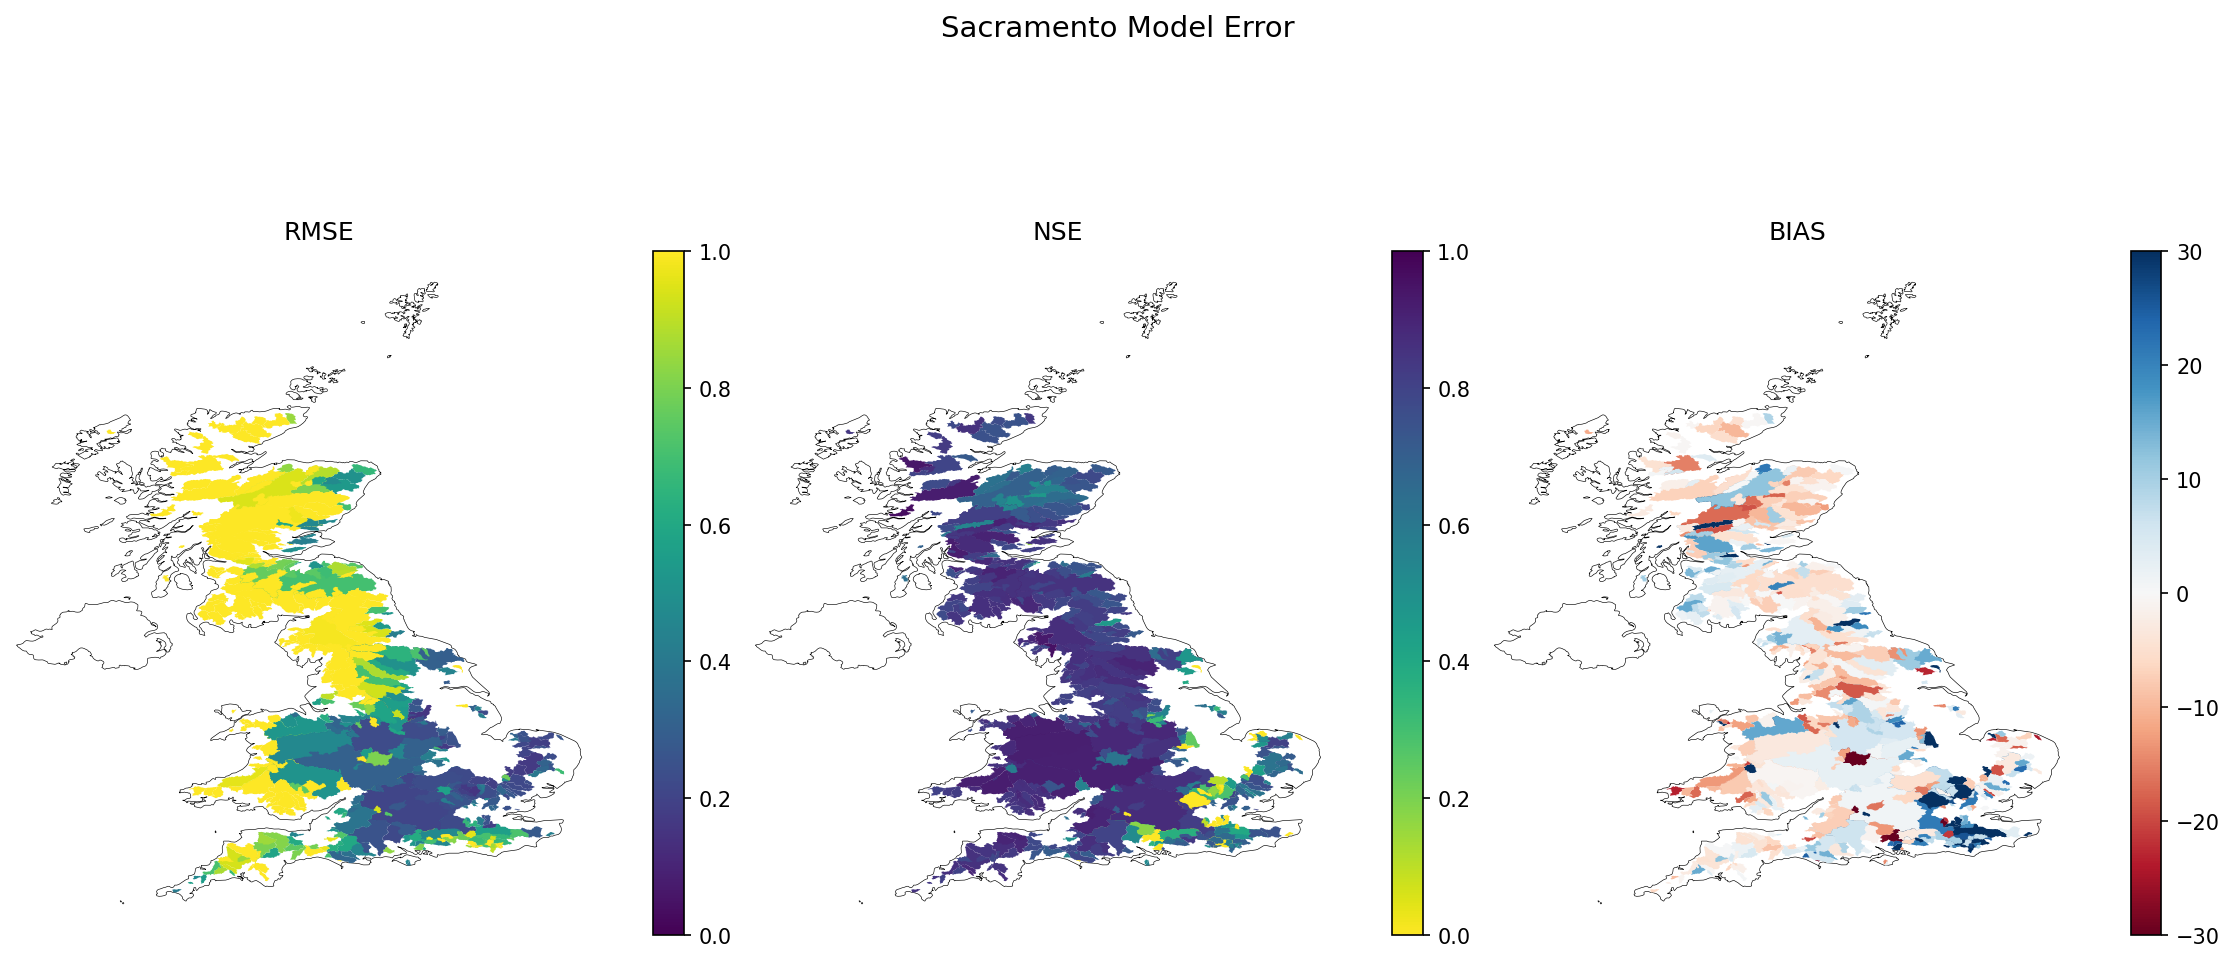

In [171]:
plot_geospatial_data(vic_gdf, model="VIC")
plot_geospatial_data(prms_gdf, model="PRMS")
plot_geospatial_data(top_gdf, model="TOPMODEL")
plot_geospatial_data(sac_gdf, model="Sacramento")